# Tomato Leaf Classification

# Imports

In [28]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, MaxPool2D, Flatten, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

# Constants

In [4]:
PATH = "/Users/maukanmir/Downloads/archive/"
BATCH_SIZE=64
INPUT_SHAPE = (224,224,3)

train_path, val_path, test_path = PATH +"train/", PATH +"valid/", PATH +"test/"

# Functions

In [31]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_process(img_path, target_size=INPUT_SHAPE):
  try:
    with Image.open(img_path) as img:
      img = img.resize(target_size[:2])
      img = img.convert("RGB")
      
      img_arr = np.array(img)/255.0
      img_arr = img_arr.astype(np.float32)
      return img_arr
  except IOError as e:
    print(f"This Image was not able to be processed: {e}")
    return None

def grab_images(path, size=None):
  
  images, labels = [], []
  
  for root, dirs, files in os.walk(path):
    for file in files:
      if size and len(labels) == size:
        return np.array(images), np.array(labels)
      if file.lower().endswith((".png", ".jpg", ".jpeg")):
        img_path = os.path.join(root, file)
        img = load_process(img_path)
        if img is not None:
          images.append(img)
          label = root.split(os.sep)[-1]
          labels.append(label)
  
  images, labels = np.array(images), np.array(labels)
  return images, labels

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 8))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10,12))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def create_model(n_classes, input_shape=INPUT_SHAPE):
  
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=INPUT_SHAPE),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Conv2D(356, (3,3), activation="relu"),
    MaxPool2D(2,2),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(n_classes, activation="softmax")
  ])
  
  model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  
  model.summary()
  
  return model

def plot_images(images, labels, num_images=12, img_size=INPUT_SHAPE):
  
  indices = np.arange(len(images))
  np.random.shuffle(indices)
  plt.figure(figsize=(10,10))
  
  for i in range(num_images):
    plt.subplot(3,4, i+1)
    idx = indices[i]
    img = images[idx].reshape(img_size)
    plt.imshow(img)
    plt.title(labels[idx])
    plt.axis("off")
  plt.show()
  

# Load Images

In [6]:
X_train, y_train = grab_images(train_path, 2500)
X_val, y_val = grab_images(val_path, 1000)
X_test, y_test = grab_images(test_path, 1000)

In [7]:
print(f"Training shape: {X_train.shape[0]}, {y_train.shape[0]}")
print(f"Validation shape: {X_val.shape[0]}, {y_val.shape[0]}")
print(f"Test shape: {X_test.shape[0]}, {y_test.shape[0]}")

Training shape: 2500, 2500
Validation shape: 1000, 1000
Test shape: 1000, 1000


# EDA Analysis

# Check Class Imabalance

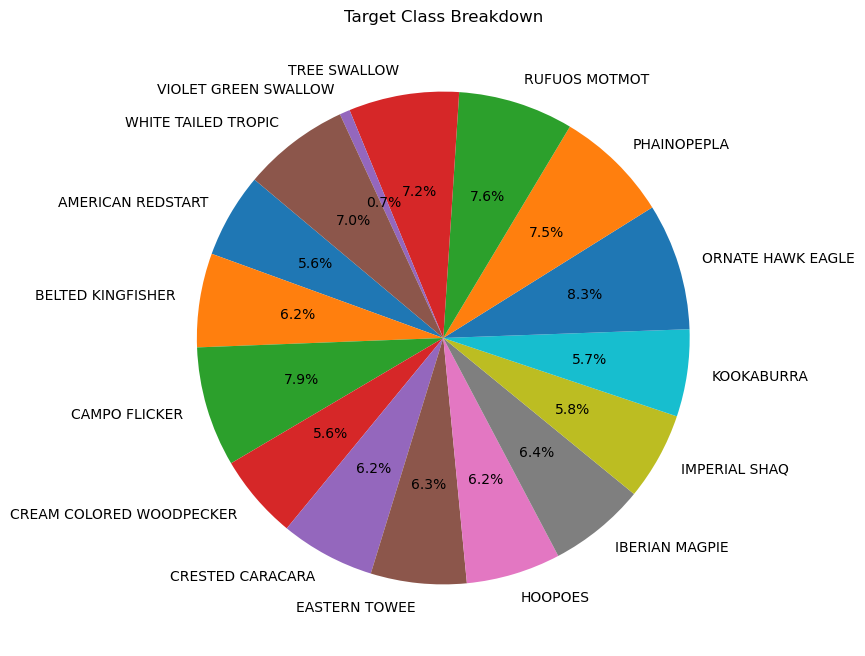

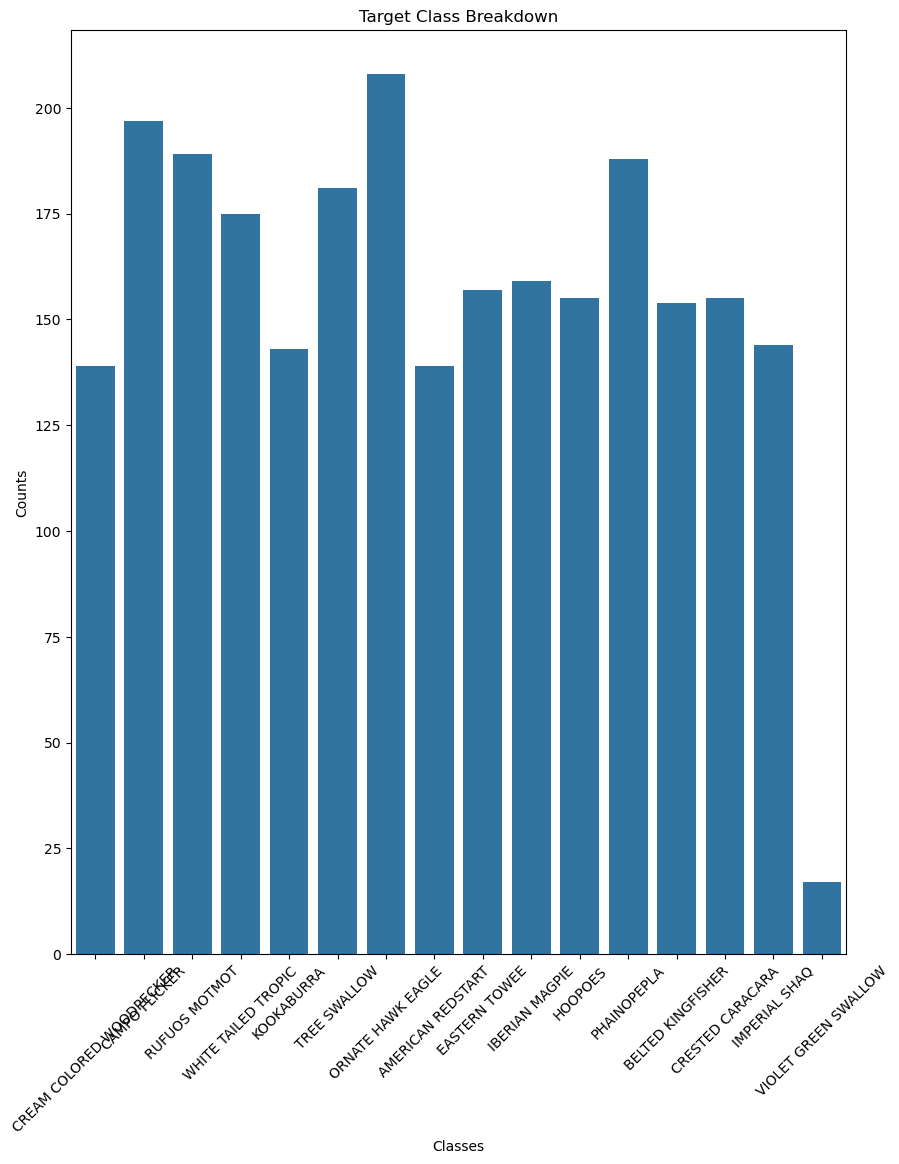

In [27]:
check_class_imbalance(y_train)

# Target class has some rare birds

# First look at our images

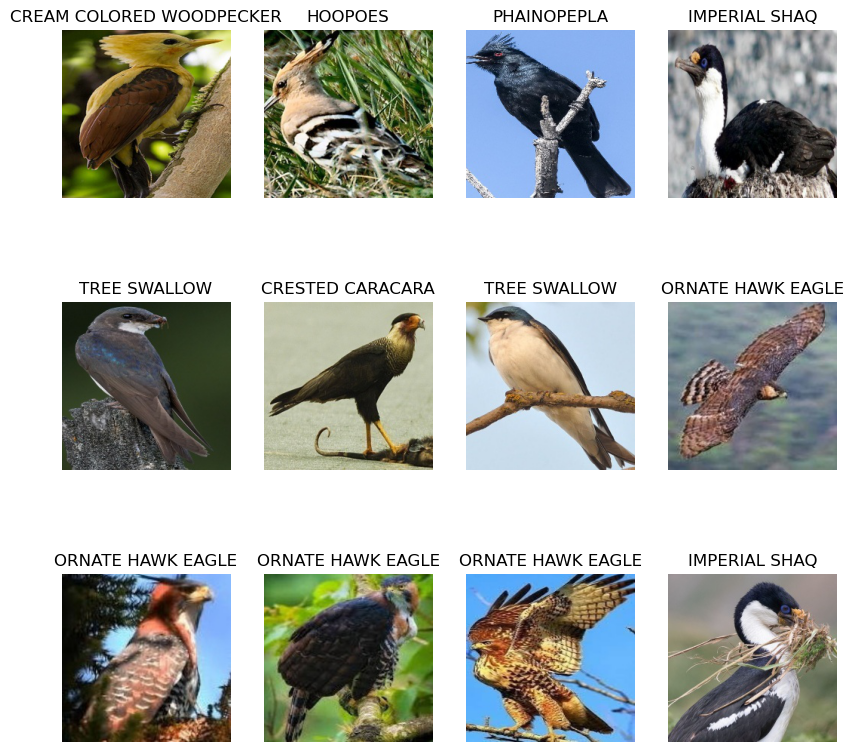

In [32]:
plot_images(X_train,y_train)

# We should incorporate data augmentation to ensure our model generalizes to unseen images